<a href="https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist3D.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

<a href="https://github.com/WinetraubLab/OCT2Hist-ModelInference/blob/main/run_oct2hist3D.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to convert OCT 3D volume (stored in .tiff)  to virtual histology.


In [1]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown Input Image Path
# Path to the OCT image
input_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/LG-44/" # @param {type:"string"}
oct_input_volume_name = "VolumeScanAbs_All_LG-44.tiff" # @param {type:"string"}
oct_input_volume_path = input_folder + oct_input_volume_name

# OCT image's pixel size
microns_per_pixel_z = 1
microns_per_pixel_x = 1
microns_per_pixel_y = 1

# @markdown Cropping Parameters
x0 = 0 # @param {type:"slider", min:0, max:1000, step:10}
z0_start = 250 # @param {type:"slider", min:0, max:400, step:10}
z0_end = 250 # @param {type:"slider", min:0, max:400, step:10}

# @markdown Output Image Path (same folder as input_folder)
output_tiff_name = "VirtualHE.tif" # @param {type:"string"}
output_tiff_path = input_folder + output_tiff_name
# @markdown Output Parameters
section_separation_um = 5 # @param {type:"slider", min:1, max:20, step:1}

## Set Up Environment

In [2]:
if not 'setup_env_oct2Hist_usemodel' in globals():
  setup_env_oct2Hist_usemodel = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
  !pip install imageio
  %cd OCT2Hist-ModelInference

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import oct2hist
from utils.show_images import *
from google.colab import drive
from utils.crop import crop
import os
import shutil
from tqdm import tqdm
drive.mount('/content/drive/')

fatal: destination path 'OCT2Hist-ModelInference' already exists and is not an empty directory.
/content/OCT2Hist-ModelInference
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Set up the network environment
oct2hist.setup_network()

Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/' already exists.
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/oct2hist/' already exists.
Mounting drive: if it takes >30 sec, re-run.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive mounted.


In [4]:
def merge_tiff_files(input_folder, output_file):
    # Get a list of all TIFF files in the input folder
    tiff_files = [file for file in os.listdir(input_folder) if file.lower().endswith('.png')]

    # Sort the files if needed
    tiff_files.sort()

    # Open all TIFF files
    images = [Image.open(os.path.join(input_folder, file)) for file in tiff_files]

    # Save as multi-page TIFF
    images[0].save(output_file, save_all=True, append_images=images[1:])

## Run
In this step we load the OCT image, then crops it to the right size



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]
/content/OCT2Hist-ModelInference/utils/masking.py:80: RuntimeWarning: invalid value encountered in cast
  img = (float_img*255).astype(np.uint8)


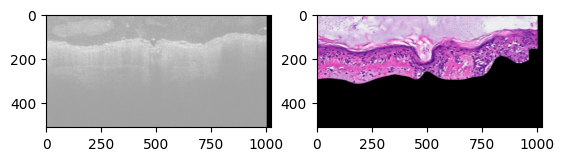

In [5]:
# @title Visualize one of the slides
# Configuration
min_signal_threshold = np.nan

# Check if file exists
if not os.path.exists(input_folder):
  raise FileNotFoundError(f"The directory {input_folder} does not exist.")
if not os.path.exists(oct_input_volume_path):
  !ls "{input_folder}"
  raise FileNotFoundError(f"The directory exists but the file {oct_input_volume_name} does not exist.")

# Crop
oct_image = cv2.imread(oct_input_volume_path)
cropped = crop(oct_image, target_width=1024, target_height=512, x0=x0, z0=z0_start)

# Run Inference
virtual_histology_image, *_ = oct2hist.run_network(
  cropped,
  microns_per_pixel_x = microns_per_pixel_x,
  microns_per_pixel_z = microns_per_pixel_z,
  min_signal_threshold = min_signal_threshold
  )

showTwoImgs(cropped, virtual_histology_image)

In [6]:
# @title Process the rest

# Load OCT image
_, oct_volume = cv2.imreadmulti(oct_input_volume_path)
oct_volume = np.asarray(oct_volume)

# Create z0 grid
z0 = np.round(np.linspace(z0_start,z0_end,oct_volume.shape[0])).astype(int)

# Create a temporary folder for individual scans
tmp_folder = '/content/tmp/'
if os.path.exists(tmp_folder):
    shutil.rmtree(tmp_folder)
    print(f"Folder '{tmp_folder}' deleted.")
os.makedirs(tmp_folder) # Create a new folder

# Loop over entire volume convert and append to outputfile
for i in tqdm(
    range(0,oct_volume.shape[0],int(section_separation_um/microns_per_pixel_y)),
    desc="Converting OCT to Histology", unit="image"):
  # Crop
  oct_image = cv2.cvtColor(oct_volume[i,:,:], cv2.COLOR_GRAY2BGR)
  cropped = crop(oct_image, target_width=1024, target_height=512, x0=x0, z0=z0[i])

  # Run Inference
  virtual_histology_image, *_ = oct2hist.run_network(
    cropped,
    microns_per_pixel_x = microns_per_pixel_x,
    microns_per_pixel_z = microns_per_pixel_z,
    min_signal_threshold = min_signal_threshold
    )

  # Undo any cropping and bring back to OCT resolution
  padded_image = np.zeros_like(oct_image)
  oct_height, oct_width, _ = oct_image.shape
  vhist_height, vhist_width, _ = virtual_histology_image.shape
  height = min(oct_height, vhist_height)
  width = min(oct_width, vhist_width)
  padded_image[z0[i]:height, 0:width, :] = virtual_histology_image[0:height-z0[i], 0:width, :]
  virtual_histology_image = padded_image

  # Save to tmp file
  filepath = tmp_folder + "{0:04}.png".format(i)
  bgr_image = cv2.cvtColor(virtual_histology_image, cv2.COLOR_RGB2BGR)
  cv2.imwrite(filepath, bgr_image)

# Combine files to one volume
print('Exporting file to: ' + output_tiff_path)
merge_tiff_files(tmp_folder,output_tiff_path)

KeyboardInterrupt: 